Missing values:
 age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalch       0
exang        0
oldpeak     62
slope        0
thal         0
num          0
dtype: int64
Class distribution:
 num
1    468
0    378
Name: count, dtype: int64
Initial Accuracy: 0.7764705882352941
Initial Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74        76
           1       0.79      0.82      0.80        94

    accuracy                           0.78       170
   macro avg       0.77      0.77      0.77       170
weighted avg       0.78      0.78      0.78       170

Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Best Accuracy: 0.7235294117647059
Best Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73        76
           1       0.82      0.64      0.72        94

 

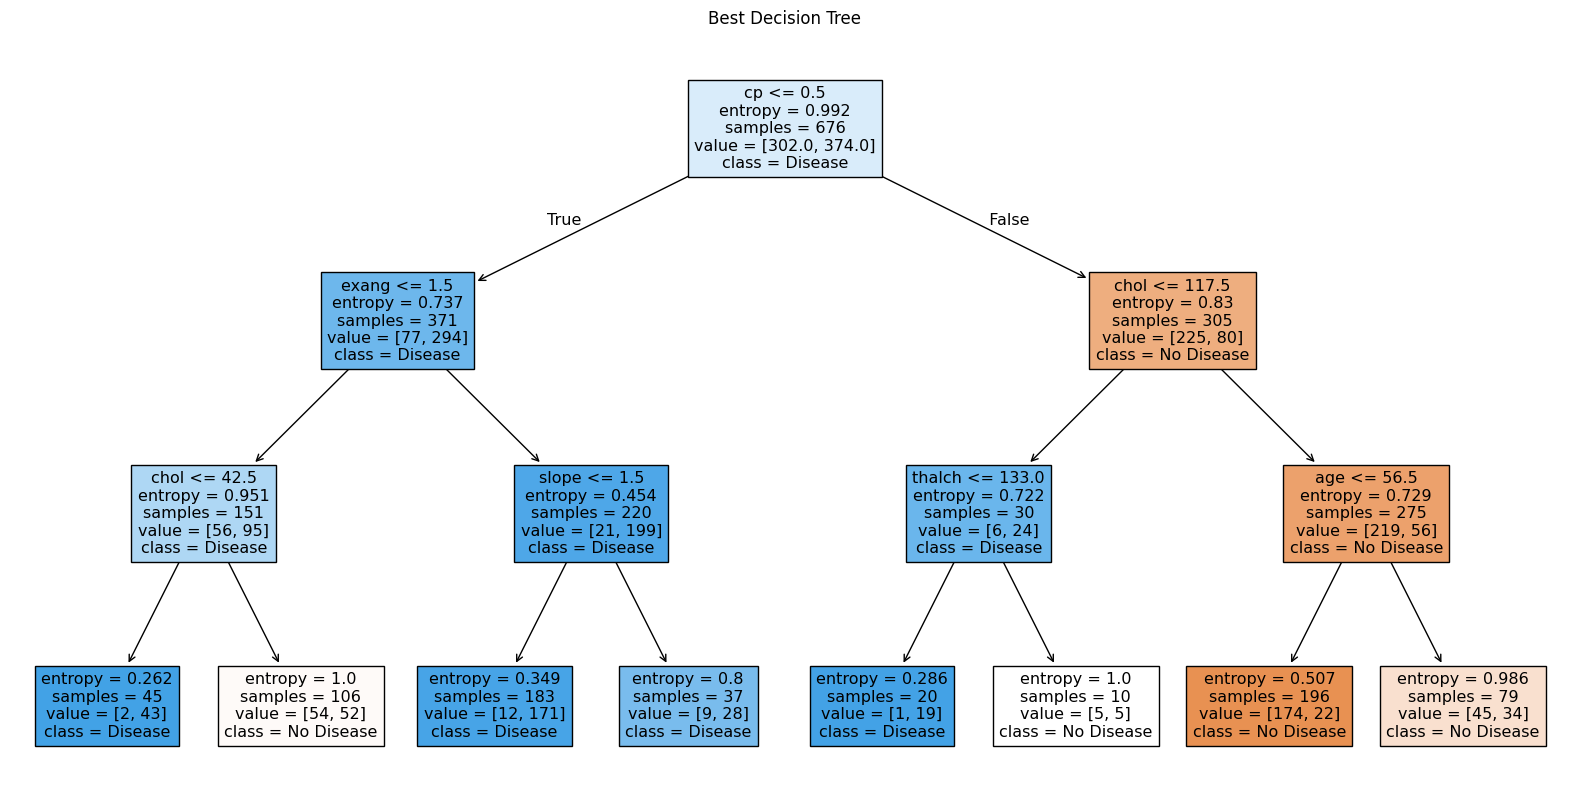

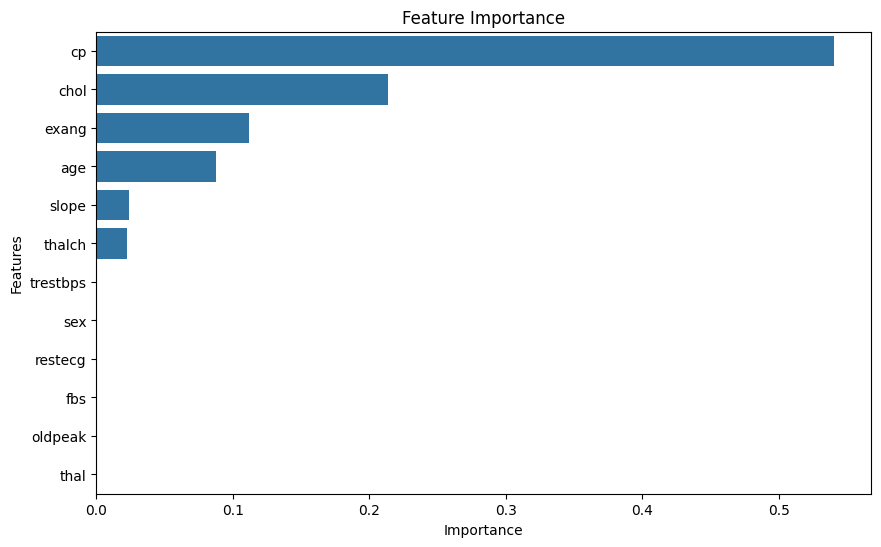

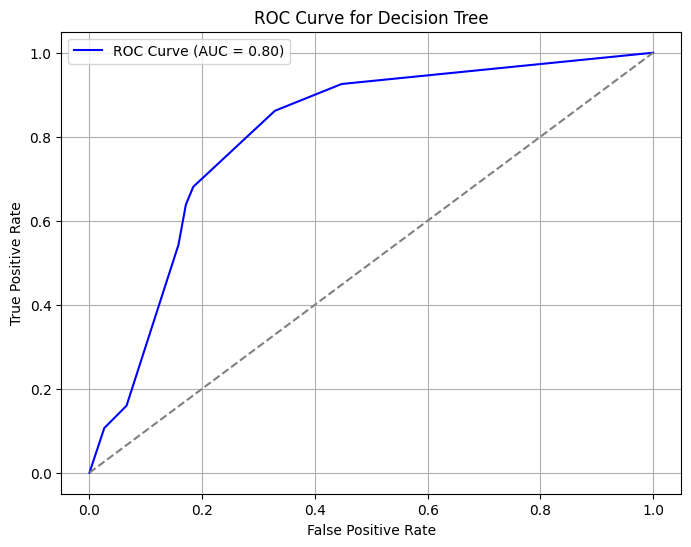

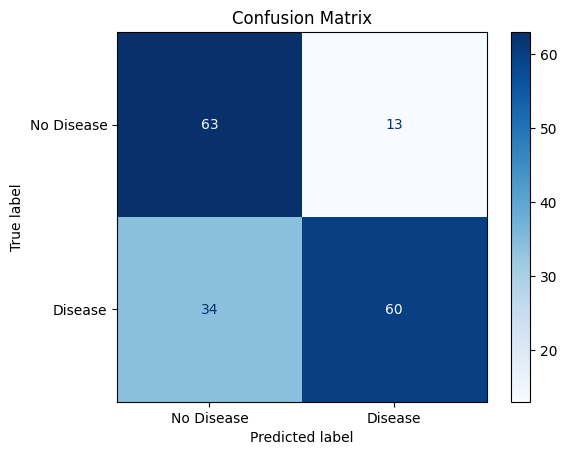

In [9]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Load the dataset
df = pd.read_excel("heart_disease.xlsx")  # Ensure the file is in the same directory

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Convert boolean columns to string
for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(str)

# Re-check all columns that are not numeric (object or mixed)
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'bool':
        df[col] = df[col].astype(str)  # ensure uniformity
        df[col] = LabelEncoder().fit_transform(df[col])








# Set features and target
X = df.drop('num', axis=1)
y = df['num'].apply(lambda x: 1 if x > 0 else 0)  # Binary classification

print("Class distribution:\n", y.value_counts())

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train basic model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Initial metrics
print("Initial Accuracy:", accuracy_score(y_test, y_pred))
print("Initial Classification Report:\n", classification_report(y_test, y_pred))

# GridSearchCV for best params
params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)
print("Best Accuracy:", accuracy_score(y_test, best_model.predict(X_test)))
print("Best Classification Report:\n", classification_report(y_test, best_model.predict(X_test)))

# Decision tree visualization
plt.figure(figsize=(20,10))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=["No Disease", "Disease"])
plt.title("Best Decision Tree")
plt.show()

# Feature importance
feat_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# ROC-AUC
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Decision Tree")
plt.legend()
plt.grid()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
